# NNの計算結果検討

In [1]:
#import
import sys
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. 各種関数

### ANN定義

In [156]:
def data_shaping_ANN(input_signal, signal, sampling, tap, max_tap, n):
    x = np.zeros((len(input_signal) // n - (max_tap - 1), sampling * tap * 2), dtype=float)
    y = np.zeros((len(input_signal) // n - (max_tap - 1), 2), dtype=float)
    if sampling == 1:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                x[i, j * 2] = signal[n * (center - tap // 2 + j) + n // 2].real
                x[i, j * 2 + 1] = signal[n * (center - tap // 2 + j) + n // 2].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    else:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                for k, sample in enumerate([round(_ * n / sampling) for _ in range(sampling)]):
                    x[i, j * sampling * 2 + k * 2] = signal[n * (center - tap // 2 + j) + sample].real
                    x[i, j * sampling * 2 + k * 2 + 1] = signal[n * (center - tap // 2 + j) + sample].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    return x, y


class Dataset_ANN(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)


class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
        if activation == 'ReLU':
            self.activation = F.relu
        elif activation == 'Sigmoid':
            self.activation = torch.sigmoid
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


def evm_score(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    if type(tmp) is np.float64:
        evm = np.sqrt(tmp / len(y_pred))
    else:
        evm = torch.sqrt(tmp / len(y_pred))
    return evm

### CVNN定義

In [143]:
def data_shaping_CVNN(input_signal, signal, sampling, tap, max_tap, n):
    x = np.zeros((len(input_signal) // n - (max_tap - 1), sampling * tap, 2), dtype=float)
    y = np.zeros((len(input_signal) // n - (max_tap - 1), 2), dtype=float)
    if sampling == 1:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                x[i, j * 2, 0] = signal[n * (center - tap // 2 + j) + n // 2].real
                x[i, j * 2, 1] = signal[n * (center - tap // 2 + j) + n // 2].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    else:
        for i, center in enumerate(range(max_tap // 2, len(input_signal) // n - max_tap // 2)):
            for j, symbol in enumerate(range(tap)):
                for k, sample in enumerate([round(_ * n / sampling) for _ in range(sampling)]):
                    x[i, j * sampling + k, 0] = signal[n * (center - tap // 2 + j) + sample].real
                    x[i, j * sampling + k, 1] = signal[n * (center - tap // 2 + j) + sample].imag
            y[i, 0] = input_signal[n // 2 + n * center].real
            y[i, 1] = input_signal[n // 2 + n * center].imag
    return x, y


class Dataset_CVNN(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        
        x = torch.Tensor(x)
        y = torch.Tensor(y)
        
        x_i = x[:, 0]
        x_q = x[:, 1]
        y_i = y[0]
        y_q = y[1]
        return x_i, x_q, y_i, y_q


class CSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = torch.sigmoid(x_i), torch.sigmoid(x_q)
        return x_i, x_q

    
class ZReLU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        for i in range(x_i.shape[0]):
            for j in range(x_i.shape[1]):
                if x_i[i, j] < 0 or x_q[i, j] < 0:
                    x_i[i, j] = 0
                    x_q[i, j] = 0
        return x_i, x_q


class CReLU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = F.relu(x_i), F.relu(x_q)
        return x_i, x_q


class modReLU(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.b = torch.tensor(-math.sqrt(1 / in_features), requires_grad=True)
    
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        norm = torch.sqrt(x_i ** 2 + x_q ** 2)
        
        out_i = F.relu(norm + self.b) * x_i / norm
        out_q = F.relu(norm + self.b) * x_q / norm
        return out_i, out_q


class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # 重み定義 Xavierの初期値
        k = 1 / in_features
        weight_i = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_i = nn.Parameter(weight_i)
        weight_q = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_q = nn.Parameter(weight_q)
        
        bias_i = torch.empty(out_features).uniform_(-k, k)
        self.bias_i = nn.Parameter(bias_i)
        bias_q = torch.empty(out_features).uniform_(-k, k)
        self.bias_q = nn.Parameter(bias_q)
        
    def forward(self, x_i, x_q):
        i = nn.functional.linear(x_i, self.weight_i) - nn.functional.linear(x_q, self.weight_q) + self.bias_i
        q = nn.functional.linear(x_i, self.weight_q) + nn.functional.linear(x_q, self.weight_i) + self.bias_q
        return i, q


class CVNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super().__init__()
        self.fc1 = ComplexLinear(input_dim, hidden_neuron)
        self.fc2 = ComplexLinear(hidden_neuron, output_dim)
        if activation == 'CSigmoid':
            self.activation = CSigmoid()
        elif activation == 'ZReLU':
            self.activation = ZReLU()
        elif activation == 'CReLU':
            self.activation = CReLU()
        elif activation == 'modReLU':
            self.activation = modReLU(input_dim)
    
    def forward(self, x_i, x_q):
        x_i, x_q = self.fc1(x_i, x_q)
        x_i, x_q = self.activation(x_i, x_q)
        x_i, x_q = self.fc2(x_i, x_q)
        return x_i, x_q


"""def evm_score_CVNN(x_i, x_q, y_i, y_q):
    tmp = 0
    for i in range(len(x_i)):
        tmp += ((x_i[i] - y_i[i]) ** 2 + (x_q[i] - y_q[i]) ** 2) / (y_i[i] ** 2 + y_q[i] ** 2)
    evm = torch.sqrt(tmp / len(x_i))
    return evm""";

### データ読み込み

In [4]:
def load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax):
    if model_type == 'ANN':
        data_shaping = data_shaping_ANN
    elif model_type == 'CVNN':
        data_shaping = data_shaping_CVNN
    
    if signal_info['signal_type'] == 'prbs':
        return load_prbs(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)
    elif signal_info['signal_type'] == 'random':
        return load_random(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)
    elif signal_info['signal_type'] == 'image':
        return load_image(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax)

In [5]:
def load_prbs(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    N = signal_info['N']
    itr = signal_info['itr']
    signal_condition = 'N=='+str(N)+'&itr=='+str(itr)
    signal_list = [N, itr] + [None] * 6
    
    # prbs.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'prbs.csv', index_col=0)
    
    # prbs.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if prbs.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        sys.exit()
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        if lc:
            sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
        else:
            sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
        x, y = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
        return x, y, signal_condition, signal_list

In [6]:
def load_random(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    seed = signal_info['seed']
    bit_num = signal_info['bit_num']
    signal_condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    signal_list = [None] * 2 + [seed, bit_num] + [None] * 4
    
    # random.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'random.csv', index_col=0)
    
    # random.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if random.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        sys.exit()
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        if lc:
            sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
        else:
            sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
        x, y = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
        return x, y, signal_condition, signal_list

In [7]:
def load_image(signal_info, trans_condition, data_shaping, lc, sampling, tap, max_tap, n, Lmax):
    target_dir = signal_info['target_dir']
    step = signal_info['step']
    image_number = signal_info['image_number']
    image_number_split = image_number.split(', ')
    ebtb = signal_info['ebtb']
    signal_condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
    signal_list = [None] * 4 + [target_dir, step, image_number, ebtb]
    
    # image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'image.csv', index_col=0)
    
    x = None
    y = None
    for i in range(len(image_number_split)):
        # image.csvにおいて、指定した伝送条件を見たす行を抜き出す
        t_query = t_df.query('target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb) + '&' + trans_condition)
        
        # if image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
        if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
            print('指定された伝送条件の信号が存在しません')
            sys.exit()
        else:
            # 伝送信号を学習データに整形する
            sgnl = load_pickle(t_query.iloc[0]['data_path'])
            if lc:
                sgnl_distorted = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
            else:
                sgnl_distorted = sgnl.signal['x_' + str(Lmax)]
            x_tmp, y_tmp = data_shaping(sgnl.signal['x_0'], sgnl_distorted, sampling, tap, max_tap, n)
            if x is None:
                x = x_tmp
                y = y_tmp
            else:
                x = np.concatenate([x, x_tmp])
                y = np.concatenate([y, y_tmp])
    return x, y, signal_condition, signal_list

In [17]:
def prepare_input(model_info, signal_info, tap, PdBm):
    model_type = model_info['model_type']
    lc = model_info['linear_compensation']
    sampling = model_info['sampling']
    #tap = model_info['tap']
    batch_size = model_info['batch_size']
    neuron = model_info['neuron']
    epochs = model_info['epochs']
    lr = model_info['lr']
    activation = model_info['activation']
    form = model_info['form']
    #PdBm = model_info['PdBm']
    Lmax = model_info['Lmax']
    
    max_tap = 501
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    
    # 指定した学習条件と伝送条件
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    
    x, y, _, _ = load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax)
    return x, y

### Model読み込み

In [52]:
def load_model(learn_condition, trans_condition, signal_condition, model_type, device, sampling, tap, neuron, epochs, activation, Lmax):
    l_df_dir = '../data/params/' + model_type + '.csv'
    l_df = pd.read_csv(l_df_dir, index_col=0)

    # ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(learn_condition + '&' + signal_condition + '&' + trans_condition + '&Lmax=='+str(Lmax))

    #if epochsを含む指定された条件を満たす結果がある: 何もしない
    if len(l_query) == 0 or l_query['epochs'].max() < epochs:
        print('指定された条件の学習結果は存在しません')
    else:
        index = l_query['epochs'].idxmax()
        if model_type == 'ANN':
            model = ANN(input_dim=sampling*tap*2, output_dim=2, hidden_neuron=neuron, activation=activation).to(device)
        elif model_type == 'CVNN':
            model = CVNN(input_dim=sampling*tap, output_dim=1, hidden_neuron=neuron, activation=activation).to(device)
        model.load_state_dict(torch.load(l_query['params_path'][index]))
    return model

In [53]:
def prepare_model(model_info, signal_info, tap, PdBm):
    device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
    # print('Device available now:', device)
    
    model_type = model_info['model_type']
    lc = model_info['linear_compensation']
    sampling = model_info['sampling']
    #tap = model_info['tap']
    batch_size = model_info['batch_size']
    neuron = model_info['neuron']
    epochs = model_info['epochs']
    lr = model_info['lr']
    activation = model_info['activation']
    form = model_info['form']
    #PdBm = model_info['PdBm']
    Lmax = model_info['Lmax']
   
    max_tap = 501
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    
    # 指定した学習条件と伝送条件
    learn_condition = 'linear_compensation=='+str(lc)+'&sampling=='+str(sampling)+'&tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&epochs=='+str(epochs)+'&learning_rate=='+str(lr)+'&activation=="'+str(activation)+'"'
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    
    x, y, signal_condition, _ = load_signal(signal_info, trans_condition, model_type, lc, sampling, tap, max_tap, n, Lmax)
    if x is not None:
        model = load_model(learn_condition, trans_condition, signal_condition, model_type, device, sampling, tap, neuron, epochs, activation, Lmax)
        
        if model is not None:
            # 平均,標準偏差の計算
            mean = np.mean(x)
            std = np.std(x)
            
            return model, mean, std

### 予測

In [31]:
def predict_ANN(x, y, model_info, signal_info, tap, PdBm):
    model, mean, std = prepare_model(model_info, signal_info, tap, PdBm)
    dataset = Dataset_ANN(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=model_info['batch_size'], shuffle=False)
    
    nnc = np.empty((0, 2), float)
    y = np.empty((0, 2), float)
    for x_bat, y_bat in dataloader:
        out = model(x_bat)
        nnc = np.append(nnc, out.detach().numpy().reshape(-1, 2) * std + mean, axis=0)
        y = np.append(y, (y_bat.detach().numpy().reshape(-1, 2) * std + mean).astype(np.int32), axis=0)
    return nnc, y

In [56]:
def predict_CVNN(x, y, model_info, signal_info, tap, PdBm):
    model, mean, std = prepare_model(model_info, signal_info, tap, PdBm)
    dataset = Dataset_CVNN(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=model_info['batch_size'], shuffle=False)
    
    nnc_i = np.empty(0, float)
    nnc_q = np.empty(0, float)
    y_i = np.empty(0, float)
    y_q = np.empty(0, float)
    for x_bat_i, x_bat_q, y_bat_i, y_bat_q in dataloader:
        out_i, out_q = model(x_bat_i, x_bat_q)
        nnc_i = np.append(nnc_i, out_i.detach().numpy() * std + mean)
        nnc_q = np.append(nnc_q, out_q.detach().numpy() * std + mean)
        y_i = np.append(y_i, (y_bat_i.detach().numpy() * std + mean).astype(np.int32))
        y_q = np.append(y_q, (y_bat_q.detach().numpy() * std + mean).astype(np.int32))
    
    nnc = np.hstack([nnc_i.reshape(-1, 1), nnc_q.reshape(-1, 1)])
    y = np.hstack([y_i.reshape(-1, 1), y_q.reshape(-1, 1)])
    return nnc, y

### コンスタレーション

In [15]:
def display_constellation(nnc, y):
    evm = round(evm_score(nnc, y) * 100, 2)
    nnc = nnc[:, 0] + nnc[:, 1] * 1j
    y = y[:, 0] + y[:, 1] * 1j
    
    symbol, inverse, counts = np.unique(y, return_inverse=True, return_counts=True)
    cm = plt.get_cmap('rainbow', 16)
    boxdic = {
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1}
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(symbol)):
        ax.plot(nnc[y == symbol[i]].real, nnc[y == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
    for i in range(len(symbol)):
        ax.plot(y[y == symbol[i]].real, y[y == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
    ax.text(-100000, 95000, 'EVM: ' + str(evm) + '%', color='black', fontsize=20, bbox=boxdic)
    ax.set_xlim((-110000, 110000))
    ax.set_ylim((-110000, 110000))
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

### シンボル数依存性(モデル固定, 異なる信号)

In [33]:
def symbol_vs_evm(dic_list):
    taps = [1, 51, 101, 151, 201]
    evms = np.zeros((len(dic_list), 5), dtype=float)
    for i, tap in enumerate(tqdm(taps)):
        for j in range(len(dic_list)):
            if dic_list[j]['model_type'] == 'ANN':
                predict = predict_ANN
            elif dic_list[j]['model_type'] == 'CVNN':
                predict = predict_CVNN
            nnc, y= predict(tap, dic_list[j]['batch_size'], dic_list[j]['neuron'], dic_list[j]['epochs'], 
                            dic_list[j]['lr'], dic_list[j]['activation'], dic_list[j]['signal_info_model'], dic_list[j]['signal_info_input'], 
                            dic_list[j]['form'], dic_list[j]['PdBm'], dic_list[j]['Lmax'])
            evms[j, i] = evm_score(nnc, y) * 100

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(dic_list)):
        ax.plot(taps, evms[i], '-s', label=dic_list[i]['legend'])
    plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.xlabel('Number of input symbols', fontsize=18)
    plt.ylabel('EVM[%]', fontsize=18)
    #ax.set_xlim((-110000, 110000))
    #ax.set_ylim((-110000, 110000))
    ax.xaxis.set_tick_params(labelsize= 16, direction='in')
    ax.yaxis.set_tick_params(labelsize= 16, direction='in')

# 2. 可視化

## 2.1 コンスタレーション

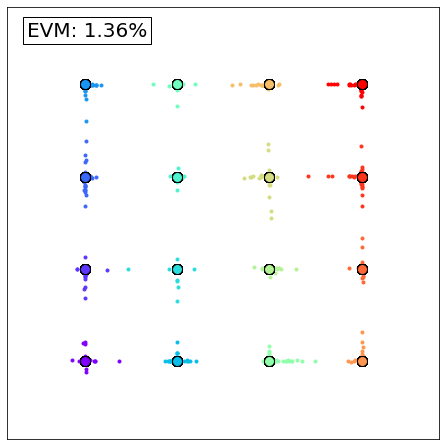

In [162]:
tap = 1
PdBm = 1

model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 4,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

#signal_info_model = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

signal_info_input = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
#signal_info_input = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}
#signal_info_input = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}

x, y = prepare_input(model_info, signal_info_input, tap, PdBm)
nnc, y = predict_ANN(x, y, model_info, signal_info_model, tap, PdBm)
display_constellation(nnc, y)

## 2.2 重み

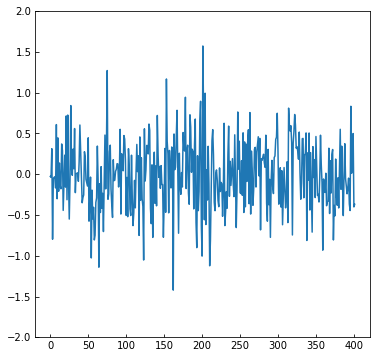

In [193]:
tap = 201
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

#signal_info_model = {'signal_type': 'prbs', 'N': 13, 'itr': 1}
#signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

model, mean, std = prepare_model(tap=tap, batch_size=batch_size, neuron=neuron, epochs=epochs, lr=lr, signal_info=signal_info_model, form=form, PdBm=PdBm, Lmax=Lmax)
weight = model.state_dict()['fc1.weight'].detach().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
for i in [7]:#, 25, 60, 98, 140, 160, 179, 226, 250, 289]:
    ax.plot(weight[i])
ax.set_ylim((-2, 2))
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')

## 2.3 グリッドサーチ

In [106]:
tap = 1
PdBm = 1

model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 0,
                          'epochs': 0,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}

signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 10000}

signal_info_input = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

epoch = [150, 200, 250, 300, 350, 400, 450, 500]
neuron = [10, 20, 40, 80, 160, 320, 640, 1280]
evms = np.zeros((8, 8), dtype=float)
for i, n in enumerate(neuron):
    for j, e in enumerate(epoch):
        model_info['neuron'] = n
        model_info['epochs'] = e
        
        x, y = prepare_input(model_info, signal_info_input, tap, PdBm)
        nnc, y = predict_ANN(x, y, model_info, signal_info_model, tap, PdBm)
        evms[i, j] = evm_score(nnc, y) * 100

{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 10, 'epochs': 150, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 10, 'epochs': 200, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 10, 'epochs': 250, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 10, 'epochs': 300, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 10, 'epochs': 350, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neur

{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 320, 'epochs': 400, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 320, 'epochs': 450, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 320, 'epochs': 500, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 640, 'epochs': 150, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 'neuron': 640, 'epochs': 200, 'lr': 0.001, 'activation': 'ReLU', 'form': 'RZ16QAM', 'Lmax': 2500}
{'model_type': 'ANN', 'linear_compensation': True, 'sampling': 1, 'batch_size': 100, 

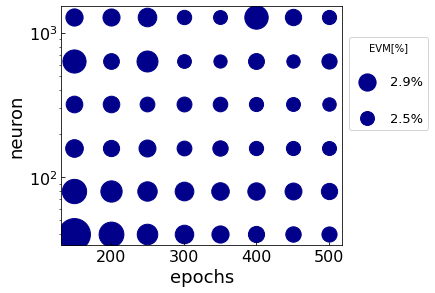

In [105]:
epoch = [150, 200, 250, 300, 350, 400, 450, 500]
neuron = [10, 20, 40, 80, 160, 320, 640, 1280]

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlabel('epochs', fontsize=18)
ax.set_ylabel('neuron', fontsize=18)
flag = [True, True, True]
evms_sort = np.sort(evms.reshape(-1))
for i in range(2, 8):
    for j in range(8):
        if evms[i][j] == evms_sort[5] and flag[0]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=50 + (evms[i][j] - 2) * 2000 / 7, label='{0}%'.format(np.round(evms[i][j], decimals=1)))
            flag[0] = False
        elif evms[i][j] == evms_sort[32] and flag[1]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=50 + (evms[i][j] - 2) * 2000 / 7, label='{0}%'.format(np.round(evms[i][j], decimals=1)))
            flag[1] = False
        elif evms[i][j] == evms_sort[-5] and flag[2]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=50 + (evms[i][j] - 2) * 2000 / 7, label='{0}%'.format(np.round(evms[i][j], decimals=1)))
            flag[2] = False
        else:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=50 + (evms[i][j] - 2) * 2000 / 7)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14, bbox_to_anchor=(1.0, 0.9), labelspacing=1.8, prop={'size': 13}, title="EVM[%]")
ax.xaxis.set_tick_params(labelsize=16, direction='in')
ax.yaxis.set_tick_params(labelsize=16, direction='in')
plt.subplots_adjust(left=0.13, bottom=0.15, right=0.78, top=0.98)

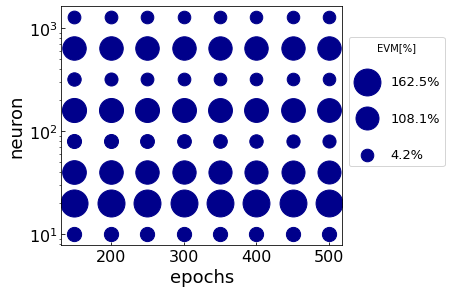

In [110]:
epoch = [150, 200, 250, 300, 350, 400, 450, 500]
neuron = [10, 20, 40, 80, 160, 320, 640, 1280]

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlabel('epochs', fontsize=18)
ax.set_ylabel('neuron', fontsize=18)
flag = [True, True, True]
evms_sort = np.sort(evms.reshape(-1))
for i in range(8):
    for j in range(8):
        if evms[i][j] == evms_sort[5] and flag[0]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=150 + (evms[i][j] - 2) * 25 / 7, label='{0}%'.format(np.round(evms[i][j], decimals=1)))
            flag[0] = False
        elif evms[i][j] == evms_sort[32] and flag[1]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=150 + (evms[i][j] - 2) * 25 / 7, label='{0}%'.format(np.round(evms[i][j], decimals=1)))
            flag[1] = False
        elif evms[i][j] == evms_sort[-5] and flag[2]:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=150 + (evms[i][j] - 2) * 25 / 7, label='{0}%'.format(np.round(evms[i][j], decimals=1)))
            flag[2] = False
        else:
            ax.scatter(epoch[j], neuron[i], c='darkblue', s=150 + (evms[i][j] - 2) * 25 / 7)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14, bbox_to_anchor=(1.0, 0.9), labelspacing=1.8, prop={'size': 13}, title="EVM[%]")
ax.xaxis.set_tick_params(labelsize=16, direction='in')
ax.yaxis.set_tick_params(labelsize=16, direction='in')
plt.subplots_adjust(left=0.13, bottom=0.15, right=0.78, top=0.98)

## 2.4 入力シンボル数 vs EVM

### 線形補償0%でNN補償 or 線形補償100%でNN補償

In [135]:
model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 10,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}
signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_test = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

In [136]:
taps = [1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501]
evms = np.zeros((4, 11), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    model_info['linear_compensation'] = True
    
    x_model, y_model = prepare_input(model_info, signal_info_model, tap, PdBm)
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    
    nnc, y = predict_ANN(x_model, y_model, model_info, signal_info_model, tap, PdBm)
    evms[0, i] = evm_score(nnc, y) * 100
    
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[1, i] = evm_score(nnc, y) * 100
    
    model_info['linear_compensation'] = False
    
    x_model, y_model = prepare_input(model_info, signal_info_model, tap, PdBm)
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    
    nnc, y = predict_ANN(x_model, y_model, model_info, signal_info_model, tap, PdBm)
    evms[2, i] = evm_score(nnc, y) * 100
    
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[3, i] = evm_score(nnc, y) * 100

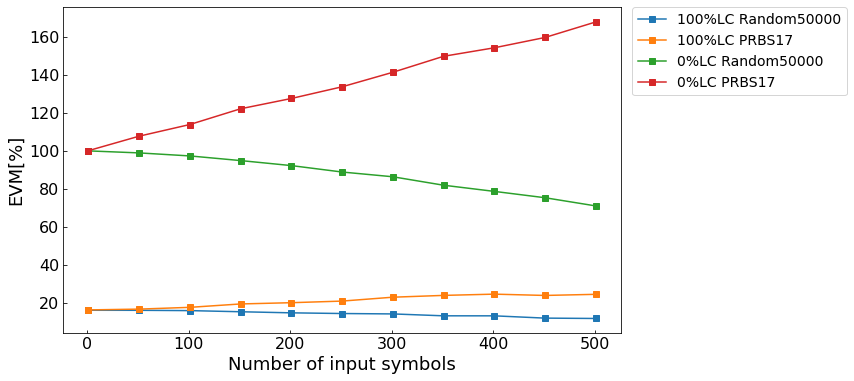

In [137]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['100%LC Random50000', '100%LC PRBS17', '0%LC Random50000', '0%LC PRBS17']
for i in range(4):
    ax.plot(taps, evms[i], '-s', label=legends[i])
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

### samplingの違い

In [163]:
model_info = {'model_type': 'ANN',
                          'linear_compensation': True,
                          'sampling': 1,
                          'batch_size': 100,
                          'neuron': 320,
                          'epochs': 500,
                          'lr': 0.001,
                          'activation': 'ReLU',
                          'form': 'RZ16QAM',
                          'Lmax': 2500}
signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 50000}

signal_info_test = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

In [164]:
taps = [1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501]
evms = np.zeros((4, 11), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    model_info['sampling'] = 1
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[0, i] = evm_score(nnc, y) * 100
    
    model_info['sampling'] = 2
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[1, i] = evm_score(nnc, y) * 100
    
    model_info['sampling'] = 3
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[2, i] = evm_score(nnc, y) * 100
    
    model_info['sampling'] = 4
    x_test, y_test = prepare_input(model_info, signal_info_test, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[3, i] = evm_score(nnc, y) * 100

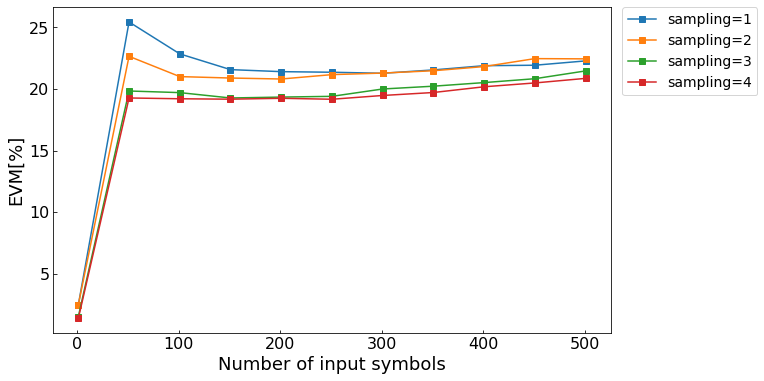

In [165]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
legends = ['sampling=1', 'sampling=2', 'sampling=3', 'sampling=4', 'sampling=5']
for i in range(4):
    ax.plot(taps, evms[i], '-s', label=legends[i])
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

In [ ]:
taps = [1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501]
evms = np.zeros((4, 11), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    model_info['sampling'] = 1
    x_test, y_test = prepare_input(model_info, signal_info_model, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[0, i] = evm_score(nnc, y) * 100
    
    model_info['sampling'] = 2
    x_test, y_test = prepare_input(model_info, signal_info_model, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[1, i] = evm_score(nnc, y) * 100
    
    model_info['sampling'] = 3
    x_test, y_test = prepare_input(model_info, signal_info_model, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[2, i] = evm_score(nnc, y) * 100
    
    model_info['sampling'] = 4
    x_test, y_test = prepare_input(model_info, signal_info_model, tap, PdBm)
    nnc, y = predict_ANN(x_test, y_test, model_info, signal_info_model, tap, PdBm)
    evms[3, i] = evm_score(nnc, y) * 100

In [10]:
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

signal_info_model_prbs0 = {'signal_type': 'prbs', 'N': 13, 'itr': 1}
signal_info_model_prbs1 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_model_random0 = {'signal_type': 'random', 'seed': 1234, 'bit_num': 10000}
signal_info_model_image0 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
signal_info_model_image1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 30, 'image_number': '0', 'ebtb': True}
signal_info_model_image2 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '0', 'ebtb': True}
signal_info_model_image3 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

signal_info_input_prbs0 = {'signal_type': 'prbs', 'N': 13, 'itr': 1}
signal_info_input_prbs1 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_input_random = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
signal_info_input_image0 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
signal_info_input_image1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}



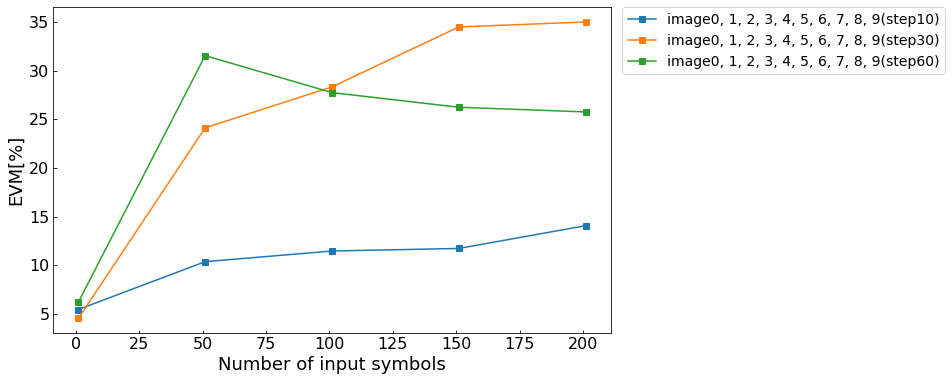

In [34]:
model_type = 'ANN'
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
activation = 'ReLU'
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

signal_info_model0 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}
signal_info_model1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 30, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}
signal_info_model2 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 60, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

signal_info_input = {'signal_type': 'prbs', 'N': 17, 'itr': 1}

dic_list = [{'model_type': model_type, 'batch_size': batch_size, 'neuron': neuron, 'epochs': epochs, 'lr': lr, 'activation': activation, 'signal_info_model': signal_info_model0, 'signal_info_input': signal_info_input, 'form': form, 'PdBm': PdBm, 'Lmax': Lmax, 'legend': 'image0, 1, 2, 3, 4, 5, 6, 7, 8, 9(step10)'},
            {'model_type': model_type, 'batch_size': batch_size, 'neuron': neuron, 'epochs': epochs, 'lr': lr, 'activation': activation, 'signal_info_model': signal_info_model1, 'signal_info_input': signal_info_input, 'form': form, 'PdBm': PdBm, 'Lmax': Lmax, 'legend': 'image0, 1, 2, 3, 4, 5, 6, 7, 8, 9(step30)'},
            {'model_type': model_type, 'batch_size': batch_size, 'neuron': neuron, 'epochs': epochs, 'lr': lr, 'activation': activation, 'signal_info_model': signal_info_model2, 'signal_info_input': signal_info_input, 'form': form, 'PdBm': PdBm, 'Lmax': Lmax, 'legend': 'image0, 1, 2, 3, 4, 5, 6, 7, 8, 9(step60)'}]

symbol_vs_evm(dic_list)

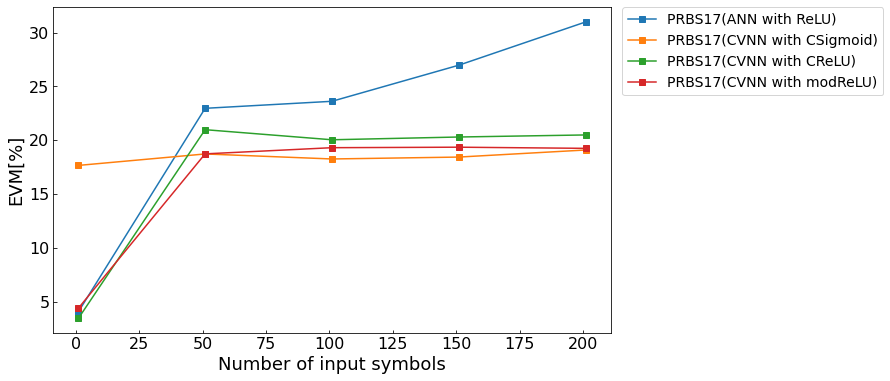

In [13]:
taps = [1, 51, 101, 151, 201]
evms = np.zeros((5, 5), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    #nnc, y= predict_ANN(tap, batch_size, neuron, epochs, lr, 'Sigmoid', signal_info_model_random0, signal_info_model_prbs1, form, PdBm, Lmax)
    #evms[0, i] = evm_score(nnc, y) * 100
    nnc, y= predict_ANN(tap, batch_size, neuron, epochs, lr, 'ReLU', signal_info_model_random0, signal_info_model_prbs1, form, PdBm, Lmax)
    evms[1, i] = evm_score(nnc, y) * 100
    nnc, y= predict_CVNN(tap, batch_size, neuron, epochs, lr, 'CReLU', signal_info_model_random0, signal_info_model_prbs1, form, PdBm, Lmax)
    evms[2, i] = evm_score(nnc, y) * 100
    nnc, y = predict_CVNN(tap, batch_size, neuron, epochs, lr, 'CReLU', signal_info_model_random0, signal_info_model_prbs1, form, PdBm, Lmax)
    evms[3, i]= evm_score(nnc, y) * 100
    nnc, y = predict_CVNN(tap, batch_size, neuron, epochs, lr, 'modReLU', signal_info_model_random0, signal_info_model_prbs1, form, PdBm, Lmax)
    evms[4, i]= evm_score(nnc, y) * 100
    
cm = plt.get_cmap('rainbow', 5)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
#ax.plot(taps, evms[0], '-s', color=[cm(0)[0], cm(0)[1], cm(0)[2]], label='PRBS17'+'(ANN trained on RS with Sigmoid)')
ax.plot(taps, evms[1], '-s', color=[cm(1)[0], cm(1)[1], cm(1)[2]], label='PRBS17'+'(ANN trained on RS with ReLU)')
ax.plot(taps, evms[2], '-s', color=[cm(2)[0], cm(2)[1], cm(2)[2]], label='PRBS17'+'(CVNN trained on RS with CReLU)')
ax.plot(taps, evms[3], '-s', color=[cm(3)[0], cm(3)[1], cm(3)[2]], label='PRBS17'+'(CVNN trained on RS with modReLU)')
ax.plot(taps, evms[4], '-s', color=[cm(4)[0], cm(4)[1], cm(4)[2]], label='PRBS17'+'(CVNN trained on RS with CSigmoid)')
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

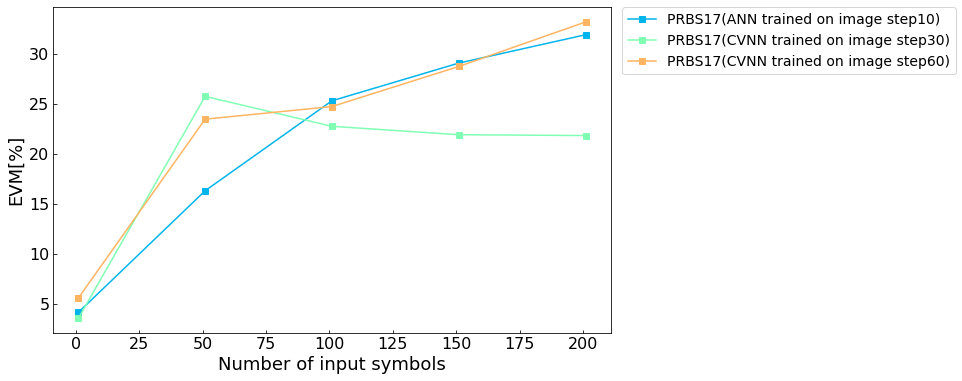

In [12]:
taps = [1, 51, 101, 151, 201]
evms = np.zeros((5, 5), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    nnc, y= predict_ANN(tap, batch_size, neuron, epochs, lr, 'Sigmoid', signal_info_model_random0, signal_info_model_prbs1, form, PdBm, Lmax)
    evms[0, i] = evm_score(nnc, y) * 100
    nnc, y= predict_ANN(tap, batch_size, neuron, epochs, lr, 'ReLU', signal_info_model_image0, signal_info_model_prbs1, form, PdBm, Lmax)
    evms[1, i] = evm_score(nnc, y) * 100
    nnc, y= predict_ANN(tap, batch_size, neuron, epochs, lr, 'ReLU', signal_info_model_image1, signal_info_model_prbs1, form, PdBm, Lmax)
    evms[2, i] = evm_score(nnc, y) * 100
    
cm = plt.get_cmap('rainbow', 5)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
#ax.plot(taps, evms[0], '-s', color=[cm(0)[0], cm(0)[1], cm(0)[2]], label='PRBS17'+'(ANN trained on RS with Sigmoid)')
ax.plot(taps, evms[1], '-s', color=[cm(1)[0], cm(1)[1], cm(1)[2]], label='PRBS17'+'(ANN trained on image step10)')
ax.plot(taps, evms[2], '-s', color=[cm(2)[0], cm(2)[1], cm(2)[2]], label='PRBS17'+'(ANN trained on image step30)')
ax.plot(taps, evms[3], '-s', color=[cm(3)[0], cm(3)[1], cm(3)[2]], label='PRBS17'+'(ANN trained on image step60)')
#ax.plot(taps, evms[4], '-s', color=[cm(4)[0], cm(4)[1], cm(4)[2]], label='PRBS17'+'(CVNN trained on RS with CSigmoid)')
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')